# importing the tools
_____

In [42]:
import warnings
warnings.filterwarnings("ignore")
from pprint import pprint
from itertools import chain
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import re 
import spacy
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim import corpora, models
from gensim.models import CoherenceModel,Phrases
from langdetect import detect
from tqdm.notebook import tqdm_notebook,tqdm
import tqdm
import pyLDAvis
import pyLDAvis.gensim_models
tqdm_notebook.pandas()

In [20]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AhmedAshraf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AhmedAshraf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AhmedAshraf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AhmedAshraf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Read the data
___

In [21]:
df = pd.read_csv("Pubmed5k.csv",encoding='windows-1252', delimiter=";",on_bad_lines='skip')
df.head(5)

,ArticleID,Title,Abstract
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...


# EDA
___

In [22]:
df.isnull().any()

ArticleID    False
Title        False
Abstract     False
dtype: bool

In [23]:
df.duplicated().any()

False

In [24]:
df.shape

(4999, 3)

# Cleaning and keeping english articles
____

#### test if there are several languages existed

In [25]:
df2=df.iloc[:4261,:]
df2=pd.concat([df2,df.iloc[4262:,:]])

#skipping one example of index 4262 for language detection

In [26]:
df2['testlang'] = df2.Abstract.progress_map(detect)

  0%|          | 0/4998 [00:00<?, ?it/s]

In [27]:
df2["testlang"].value_counts()

en    4989
ca       5
es       2
hu       1
ro       1
Name: testlang, dtype: int64

<AxesSubplot:xlabel='testlang', ylabel='count'>

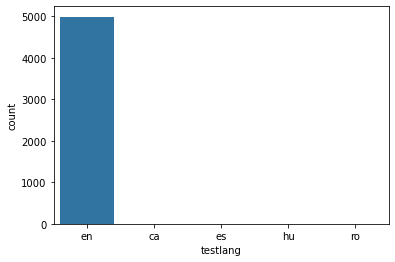

In [28]:
sns.countplot(data=df2,x="testlang")

In [29]:
df = df2.loc[df2.testlang=="en"]

In [30]:
# Remove punctuation
df['Abstract_c'] = df['Abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['Abstract_c'] = df['Abstract_c'].map(lambda x: x.lower())
# Print out the first rows of papers
df['Abstract_c'].head()

0    coordination variability (cv) is commonly anal...
1    clinical scenario: dynamic knee valgus (dkv) i...
2    various methodologies have been reported to as...
3    as outcomes for acute ischemic stroke (ais) va...
4    because hearing loss in children can result in...
Name: Abstract_c, dtype: object

In [31]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df.Abstract_c.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['coordination', 'variability', 'cv', 'is', 'commonly', 'analyzed', 'to', 'understand', 'dynamical', 'qualities', 'of', 'human', 'locomotion', 'the', 'purpose', 'of', 'this', 'study', 'was', 'to', 'develop', 'guidelines', 'for', 'the', 'number', 'of', 'trials', 'required', 'to', 'inform']


## LDA
___

#### Prepare bi-grams and tri-grams

In [32]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [33]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [34]:
spacy.load("en_core_web_sm")
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['coordination', 'cv', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'human', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'mean', 'cv', 'overground', 'locomotion', 'kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'preferred', 'fix', 'speed', 'walk', 'run', 'stance', 'phase', 'cv', 'calculate', 'segment', 'joint', 'coupling', 'use', 'modify', 'vector', 'code', 'technique', 'number', 'trial', 'require', 'achieve', 'average', 'determine', 'couple', 'individual', 'statistical', 'output', 'mode', 'walk', 'run', 'speed', 'prefer', 'fix', 'compare', 'informed', 'differ', 'number', 'trial', 'minimum', 'trial', 'require', 'stable', 'mean', 'stance', 'phase', 'cv', 'few', 'trial', 'cv', 'underestimate', 'lead', 'oversight', 'significant', 'difference', 'mode', 'speed', 'future', 'overground', 'locomotion', 'cv', 'research', 'healthy', 'population', 'use', 'vector', 'code', 'approac

#### Prepare objects for LDA gensim implementation

In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 6), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 2), (37, 2), (38, 2), (39, 1), (40, 1), (41, 4), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 3), (62, 2), (63, 2), (64, 1), (65, 1), (66, 2), (67, 1), (68, 8), (69, 1), (70, 1), (71, 2), (72, 2), (73, 2)]]


# Baseline LDA model
___

In [36]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [37]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"use" + 0.013*"method" + 0.009*"model" + 0.008*"base" + '
  '0.007*"result" + 0.006*"high" + 0.006*"show" + 0.005*"process" + '
  '0.005*"system" + 0.005*"different"'),
 (1,
  '0.011*"disease" + 0.009*"tumor" + 0.008*"treatment" + 0.007*"patient" + '
  '0.007*"case" + 0.007*"tissue" + 0.007*"level" + 0.006*"study" + '
  '0.006*"present" + 0.006*"effect"'),
 (2,
  '0.044*"patient" + 0.016*"study" + 0.013*"group" + 0.010*"treatment" + '
  '0.009*"year" + 0.009*"risk" + 0.008*"clinical" + 0.008*"use" + 0.007*"rate" '
  '+ 0.007*"include"'),
 (3,
  '0.028*"cell" + 0.021*"protein" + 0.019*"gene" + 0.010*"expression" + '
  '0.008*"identify" + 0.008*"analysis" + 0.008*"sequence" + 0.007*"use" + '
  '0.007*"study" + 0.006*"cancer"'),
 (4,
  '0.032*"water" + 0.016*"environmental" + 0.012*"concentration" + '
  '0.010*"nutrient" + 0.009*"increase" + 0.008*"polymer" + 0.008*"effect" + '
  '0.008*"ecosystem" + 0.007*"pollution" + 0.007*"river"'),
 (5,
  '0.014*"health" + 0.013*"study"

In [38]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4052097029679308


# choosing the best number of topics
___

In [39]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [40]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 10
max_topics = 16
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [14]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 67%|██████▋   | 360/540 [4:22:46<2:11:23, 43.79s/it]


In [16]:
test = pd.DataFrame(model_results)

In [17]:
test2=[]
for i in [10,11,12,13,14,15]:
    test2.append(test.loc[test["Topics"]==i]["Coherence"].max())

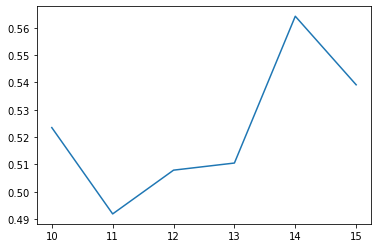

In [20]:
plt.plot([10,11,12,13,14,15],test2);


 we see that the best number of topics is **14** Depending on the Coherance

In [21]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [22]:
%matplotlib inline
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)